# PROJECT-1. Угадай знаменитость

In [10]:
# Импортируем осноные библиотеки
import numpy as np
import random 
import matplotlib.pyplot as plt
import tqdm
import time


In [11]:
# Импортируем библиотеки для глубокого обучения
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import cv2

%matplotlib inline


In [ ]:
# Определим нормализацию используя данные полученные для датасета ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]
                                 )

# Задаем трансофрмацию данных для тренировочного датасета. Изменяем размер 
# изображения, выполняем его случайное вращение в диапазоне +/- 45 градусов, 
# применяем случайное горизонтальное отражение, преобразуем изображение в 
# тензор и нормализуем каждый канал изображения
train_transform = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.RandomRotation(45),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      normalize
                                      ]
                                     )

# Для валидационного датасета не используем вращение и отражение
val_transform = transforms.Compose([transforms.Resize((224,224)), 
                                    transforms.ToTensor(),
                                    normalize
                                    ]
                                   )


In [ ]:
# Считываем данные применяя заданную трансформацию
train_dataset = ImageFolder("data/train",
                            transform=train_transform
                            )
val_dataset =  ImageFolder("data/valid",
                           transform=val_transform
                           )

# Проверим размер выборок
print(f'Количество данных в тренировочной выборке: {train_dataset.__len__()}')
print(f'Количество данных в валидационной выборке: {val_dataset.__len__()}')

Количество данных в тренировочной выборке: 3000
Количество данных в валидационной выборке: 914


In [14]:
# Зададим количество изображений в батче
batch_size = 8

# Оборачиваем датасеты в даталоадеры
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True
                                           )

val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=batch_size,
                                         shuffle=True
                                         )

In [15]:
# Так как мы используем нормализацию, то для нормального отображения 
# изображений необходимо использовать обратную трансформацию. 
# Нормализация выполняется по формуле: N = (X - mean)/std, соответственно
# обратная операция может быть выполнена по формуле 
# X = (N - (-mean/std))/(1/std) 
invert_normalize = torchvision.transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
    )
       

In [16]:
# Определим функцию для визуализации батча изображений
def batch_vizualization(data_loader):
    """Функция принимает на вход объект даталоадера и
      визализирует первый батч изображений проводя процедуру денормализации

    Args:
        data_loader (torch.utils.data.dataloader.DataLoader): объект 
        даталоадера
    """ 
    # Получаем изображения и метки их классов
    images, labels = next(iter(data_loader))
    
    # Определяем полотно соответствующее количеству изображений в батче    
    fig, axes = plt.subplots(1, images.size()[0], figsize=(16, 8))

    # Задаем цикл соответствующей количеству изображений в батче
    for i in range(images.size()[0]):
        # Проводим денормализацию каждого изображения, преобразуем в 
        # numpy массив и восстанавливаем порядок размерностей для 
        # нормального отображения [Высота, Ширина, Каналы]
        image = invert_normalize(images[i]).numpy().transpose((1, 2, 0))
        
        # Выводим изображение и имя класса в качестве наименования
        axes[i].imshow(image)
        axes[i].set_title(train_dataset.classes[labels[i]].replace("_", " "))
        axes[i].axis("off") # отключаем отображение осей
        

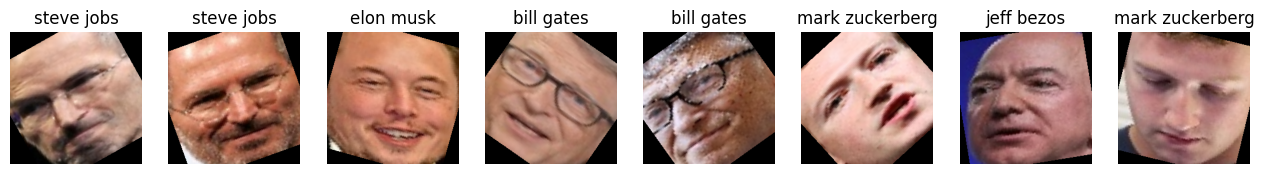

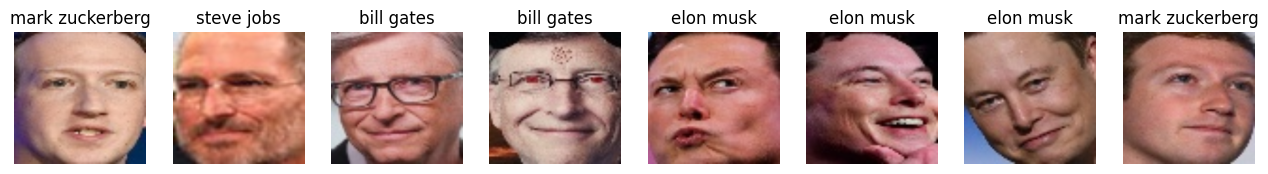

In [17]:
# Визуализируем первые батчи изображений из тренировочного
# и валидационного даталоадеров
batch_vizualization(train_loader)
batch_vizualization(val_loader)


In [18]:
# Для удобства использования создадим словарь даталоадеров
dataloaders = {'train': train_loader,
               'val': val_loader}

# Определим функцию для обучения модели
def train_model(model, device, dataloaders, criterion,
                optimizer, batch_size, num_epochs=25):
    """Функция принимает на вход модель нейронной сети, наименование 
    типа устройства для вычислений ('cpu' или 'cuda') словарь с 
    тренировочным и валидационным даталоадерами, функцию потерь, 
    оптимизатор, размер батча, и количество эпох обучения. На каждой 
    эпохе проводится обучение, валидация и подсчет статистик модели.
    Функция возвращает саму модель, и списки со статистиками. 

    Args:
        model (torchvision.models): модель нейронной сети
        device (str): тип устройства для вычислений ('cpu' или 'cuda')
        dataloaders (dict): словарь с тренировочным и валидационным 
        даталоадерами
        criterion (torch.nn.modules.loss): функция потерь
        optimizer (torch.optim): оптимизатор
        batch_size (int): размер батча
        num_epochs (int, optional): количество эпох обучения, по умолчанию 25

    Returns:
        torchvision.models, list: model - обученная модель,
         loss_train - список значений функции потерь при обучении для каждой
         эпохи,
         acc_train - список значений точности модели при обучении для каждой
         эпохи,
         loss_val - список значений функции потерь при валидации для каждой
         эпохи,
         acc_val - список значений точности модели при валидации для каждой
         эпохи
    """
    # Задаем временную метку начала работы
    start = time.time()
    
    # Определяем списки для сбора статистик
    loss_train = []
    acc_train = []
    loss_val = []
    acc_val = []

    # Задаем цикл по количеству эпох
    for epoch in range(num_epochs):
        print('-' * 10)
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # На каждой эпохе происходит обучение и валидация 
        for phase in ['train', 'val']:

            # В зависимости от текущей фазы переключаем модель
            # в режим обучения или валидации
            if phase == 'train':
                model.train()
            else:
                model.eval()

            # Задаем переменные для сбора статистик в текущей эпохе
            current_loss = 0.0
            current_corrects = 0

            # Проходим в цикле по данным
            for inputs, labels in tqdm.tqdm(dataloaders[phase]):

                # перемещаем данные на используемое устройство         
                inputs = inputs.to(device)
                labels = labels.to(device)

                # обнуляем градиенты
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):

                    # Получаем прогноз модели и считаем лосс
                    outputs = model(inputs)
                    
                    # Функция torch.max() принимает тензор и измерение в 
                    # котором требуется произвести поиск максимума,  а 
                    # возвращает сначала само значение, а затем его индекс
                    _, preds = torch.max(outputs, 1)

                    # Если последние имзерение тензора имеет единицную 
                    # размерность - избавляемся от нее (по сути если мы имеем 
                    # тезнор, содержащий тензоры с одним значением, получаем 
                    # один тензор с этими значениями) 
                    labels = labels.squeeze(-1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # считаем статистики
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels)
                
            # Считаем и выводим статистики за эпоху
            data_len = dataloaders[phase].dataset.__len__()
            epoch_loss = current_loss / data_len
            epoch_acc = current_corrects.double() / data_len
            text ='{} Loss: {:.4f} Acc: {:.4f}'.format(phase,
                                                       epoch_loss,
                                                       epoch_acc
                                                       )
            tqdm.tqdm.write(text)

            # Записываем статистики в соответствующие списки
            if phase == 'train':
                loss_train.append(epoch_loss)
                acc_train.append(epoch_acc.cpu())    
            else:
                loss_val.append(epoch_loss)
                acc_val.append(epoch_acc.cpu())
    
    # Вычисляем и выводим время завершения работы
    time_elapsed = time.time() - start
    print('Время обучения: {:.0f}m {:.0f}s'.format(time_elapsed // 60,
                                                   time_elapsed % 60
                                                   )
          )

    return model, loss_train, acc_train, loss_val, acc_val

In [19]:
# Определим функцию для визуализации процесса обучения и валидации
def loss_acc_plot(loss_train, acc_train, loss_val, acc_val):
    """Функция принимает списки  со значениями функции потерь
      и точности на обучении и валидации для каждой эпохи и 
      строит их графики

    Args:
        loss_train (list): значения функции потерь при обучении
        acc_train (list): значение метрики точности при обучении
        loss_val (list): значения функции потерь при валидации
        acc_val (list): значение метрики точности при валидации
    """
    # Задаем размер фигуры
    plt.figure(figsize=(14, 6))

    # Выбираем левую часть полотна
    plt.subplot(121)

    # Строим графики функции потерь
    plt.plot(range(1, len(loss_train) + 1),
             loss_train,
             color="b",
             label='train'
             )
    
    plt.plot(range(1, len(loss_train) + 1), loss_val, color="r", label='val')

    # Настраиваем отображение
    plt.xlabel("Номер эпохи")
    plt.title("Функция потери")
    plt.legend(loc="upper right")

    # Выбираем правую часть полотна
    plt.subplot(122)

    # Строим графики метрики точности
    plt.plot(range(1, len(loss_train) + 1),
             acc_train,
             color="b",
             label='train'
             )
    
    plt.plot(range(1, len(loss_train) + 1), acc_val, color="r", label='val')

    # Настраиваем отображение
    plt.xlabel("Номер эпохи")
    plt.title("Точность")
    plt.legend(loc="upper left")

    plt.show()
    plt.close()

In [20]:
def visualize_model(model, dataloader = dataloaders['val'], num_images=8):
    """Функция принимает на вход модель нейронной сети, даталоадер и количество 
    изображений в батче. Выбирает случайный батч изображений, получает по нему 
    предсказание модели и выводит изображения с предсказанными и реальными 
    метками класса

    Args:
        model (torchvision.models): модель нейронной сети
        dataloader (torch.utils.data.dataloader.DataLoader): объект 
         даталоадера, по умолчанию используется валидациооный даталоадер
        num_images (int, optional): количество выводимых изображений равное
         размеру батча, по умолчанию 8
    """
    # Переключаем модель в режим предсказаний
    model.eval()

    # создаем список наименований классов
    classes = train_dataset.classes
    
    # определяем фигуру
    fig = plt.figure(figsize=(6,14))
    
    # По возможности переключаемся на видеокарту
    use_gpu = torch.cuda.is_available()
    if use_gpu:
      device = 'cuda'
    else:
      device = 'cpu'
    
    # Выбираем случайный индекс батча
    ind = random.choice(range(dataloader.__len__()))

    # Задаем переменную для подсчета изображений
    images_handeled = 0  
    with torch.no_grad():
        
        # В цикл перебираем батчи
        for i, (inputs, labels) in enumerate(dataloader):
            
            # пока не дойдем до выбранного индекса
            if i == ind:
                
                # Переносим данные и модель на выбранное устройство
                model = model.to(device)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Делаем предсказание для всего батча и определяем метки классов
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                # В цикле проходим по батчу и визуализируем изображения, а также
                # их истинный и предсказанный класс
                for j in range(inputs.size()[0]):
                    images_handeled += 1

                    ax = plt.subplot(num_images//2, 2, images_handeled)
                    ax.axis('off')
                    ax.set_title('predicted: {}, \n target: {}'\
                      .format(classes[preds[j]], classes[labels[j]]))

                    # необходим перенос вектора на ЦПУ для отображения картинки
                    img = inputs.cpu()[j]
                    img = invert_normalize(img).numpy().transpose((1, 2, 0))
                    plt.imshow(img)

# Обучение моделей

In [21]:
# Проверяем возможность использования видеокарты
use_gpu = torch.cuda.is_available()
print('CUDA mode: ', use_gpu)

# Задаем устройство для вычислений
if use_gpu:
      device = 'cuda'
else:
      device = 'cpu'

# Задаем количество эпох обучения
num_epochs=25

CUDA mode:  True


В качестве предобученной модели будем использовать модель ResNet-34

In [22]:
# Загрузим модель предобученную модель resnet34
resnet34 = models.resnet34(weights='ResNet34_Weights.DEFAULT')

# Переопределим последний слой классификатора под наше количество классов
resnet34.fc = torch.nn.Linear(512, len(train_dataset.classes))

# Переносим модель на устройство
resnet34 = resnet34.to(device)

# Задаем функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet34.parameters(), lr=1e-3, weight_decay=1e-4)

# Обучим все слои нашей модели используя предобученные веса в качестве 
# начальных значений
resnet34, loss_train_resnet34, acc_train_resnet34, loss_val_resnet34,\
    acc_val_resnet34 = train_model(resnet34,
                                   device,
                                   dataloaders,
                                   criterion,
                                   optimizer,
                                   batch_size=batch_size,
                                   num_epochs=num_epochs
                                   )

----------
Epoch 1/25
----------


100%|██████████| 375/375 [00:12<00:00, 30.30it/s]


train Loss: 1.1344 Acc: 0.5843


100%|██████████| 115/115 [00:01<00:00, 70.84it/s]


val Loss: 0.8010 Acc: 0.7713
----------
Epoch 2/25
----------


100%|██████████| 375/375 [00:12<00:00, 30.81it/s]


train Loss: 0.5866 Acc: 0.8257


100%|██████████| 115/115 [00:01<00:00, 72.11it/s]


val Loss: 0.4375 Acc: 0.8993
----------
Epoch 3/25
----------


100%|██████████| 375/375 [00:12<00:00, 31.04it/s]


train Loss: 0.3820 Acc: 0.8840


100%|██████████| 115/115 [00:01<00:00, 70.31it/s]


val Loss: 0.2640 Acc: 0.9486
----------
Epoch 4/25
----------


100%|██████████| 375/375 [00:12<00:00, 30.74it/s]


train Loss: 0.3000 Acc: 0.9120


100%|██████████| 115/115 [00:01<00:00, 72.18it/s]


val Loss: 0.1944 Acc: 0.9551
----------
Epoch 5/25
----------


100%|██████████| 375/375 [00:12<00:00, 30.96it/s]


train Loss: 0.2492 Acc: 0.9287


100%|██████████| 115/115 [00:01<00:00, 70.94it/s]


val Loss: 0.1389 Acc: 0.9748
----------
Epoch 6/25
----------


100%|██████████| 375/375 [00:12<00:00, 30.87it/s]


train Loss: 0.1980 Acc: 0.9380


100%|██████████| 115/115 [00:01<00:00, 67.76it/s]


val Loss: 0.1128 Acc: 0.9792
----------
Epoch 7/25
----------


100%|██████████| 375/375 [00:12<00:00, 30.75it/s]


train Loss: 0.1888 Acc: 0.9450


100%|██████████| 115/115 [00:01<00:00, 70.02it/s]


val Loss: 0.0989 Acc: 0.9825
----------
Epoch 8/25
----------


100%|██████████| 375/375 [00:12<00:00, 30.86it/s]


train Loss: 0.1648 Acc: 0.9513


100%|██████████| 115/115 [00:01<00:00, 68.67it/s]


val Loss: 0.1058 Acc: 0.9716
----------
Epoch 9/25
----------


100%|██████████| 375/375 [00:12<00:00, 31.13it/s]


train Loss: 0.1524 Acc: 0.9537


100%|██████████| 115/115 [00:01<00:00, 72.72it/s]


val Loss: 0.0650 Acc: 0.9902
----------
Epoch 10/25
----------


100%|██████████| 375/375 [00:11<00:00, 31.44it/s]


train Loss: 0.1387 Acc: 0.9603


100%|██████████| 115/115 [00:01<00:00, 73.05it/s]


val Loss: 0.0607 Acc: 0.9869
----------
Epoch 11/25
----------


100%|██████████| 375/375 [00:12<00:00, 30.91it/s]


train Loss: 0.1114 Acc: 0.9697


100%|██████████| 115/115 [00:01<00:00, 73.64it/s]


val Loss: 0.0533 Acc: 0.9902
----------
Epoch 12/25
----------


100%|██████████| 375/375 [00:11<00:00, 31.59it/s]


train Loss: 0.1124 Acc: 0.9680


100%|██████████| 115/115 [00:01<00:00, 73.26it/s]


val Loss: 0.0468 Acc: 0.9912
----------
Epoch 13/25
----------


100%|██████████| 375/375 [00:12<00:00, 30.81it/s]


train Loss: 0.1073 Acc: 0.9710


100%|██████████| 115/115 [00:01<00:00, 71.62it/s]


val Loss: 0.0445 Acc: 0.9945
----------
Epoch 14/25
----------


100%|██████████| 375/375 [00:12<00:00, 30.74it/s]


train Loss: 0.1080 Acc: 0.9680


100%|██████████| 115/115 [00:01<00:00, 67.45it/s]


val Loss: 0.0355 Acc: 0.9956
----------
Epoch 15/25
----------


100%|██████████| 375/375 [00:12<00:00, 29.99it/s]


train Loss: 0.1005 Acc: 0.9677


100%|██████████| 115/115 [00:01<00:00, 65.17it/s]


val Loss: 0.0366 Acc: 0.9923
----------
Epoch 16/25
----------


100%|██████████| 375/375 [00:12<00:00, 30.19it/s]


train Loss: 0.0914 Acc: 0.9750


100%|██████████| 115/115 [00:01<00:00, 67.77it/s]


val Loss: 0.0323 Acc: 0.9923
----------
Epoch 17/25
----------


100%|██████████| 375/375 [00:12<00:00, 30.07it/s]


train Loss: 0.0965 Acc: 0.9767


100%|██████████| 115/115 [00:01<00:00, 66.95it/s]


val Loss: 0.0353 Acc: 0.9945
----------
Epoch 18/25
----------


100%|██████████| 375/375 [00:12<00:00, 30.16it/s]


train Loss: 0.0818 Acc: 0.9797


100%|██████████| 115/115 [00:01<00:00, 68.02it/s]


val Loss: 0.0368 Acc: 0.9923
----------
Epoch 19/25
----------


100%|██████████| 375/375 [00:12<00:00, 30.10it/s]


train Loss: 0.0731 Acc: 0.9803


100%|██████████| 115/115 [00:01<00:00, 67.18it/s]


val Loss: 0.0287 Acc: 0.9956
----------
Epoch 20/25
----------


100%|██████████| 375/375 [00:12<00:00, 30.18it/s]


train Loss: 0.0625 Acc: 0.9847


100%|██████████| 115/115 [00:01<00:00, 69.47it/s]


val Loss: 0.0306 Acc: 0.9934
----------
Epoch 21/25
----------


100%|██████████| 375/375 [00:12<00:00, 30.04it/s]


train Loss: 0.0701 Acc: 0.9803


100%|██████████| 115/115 [00:01<00:00, 67.76it/s]


val Loss: 0.0298 Acc: 0.9956
----------
Epoch 22/25
----------


100%|██████████| 375/375 [00:12<00:00, 29.90it/s]


train Loss: 0.0612 Acc: 0.9840


100%|██████████| 115/115 [00:01<00:00, 67.78it/s]


val Loss: 0.0249 Acc: 0.9956
----------
Epoch 23/25
----------


100%|██████████| 375/375 [00:12<00:00, 30.05it/s]


train Loss: 0.0689 Acc: 0.9803


100%|██████████| 115/115 [00:01<00:00, 68.63it/s]


val Loss: 0.0219 Acc: 0.9956
----------
Epoch 24/25
----------


100%|██████████| 375/375 [00:12<00:00, 30.07it/s]


train Loss: 0.0691 Acc: 0.9810


100%|██████████| 115/115 [00:01<00:00, 67.60it/s]


val Loss: 0.0222 Acc: 0.9967
----------
Epoch 25/25
----------


100%|██████████| 375/375 [00:12<00:00, 30.06it/s]


train Loss: 0.0567 Acc: 0.9833


100%|██████████| 115/115 [00:01<00:00, 69.50it/s]

val Loss: 0.0279 Acc: 0.9967
Время обучения: 5m 48s


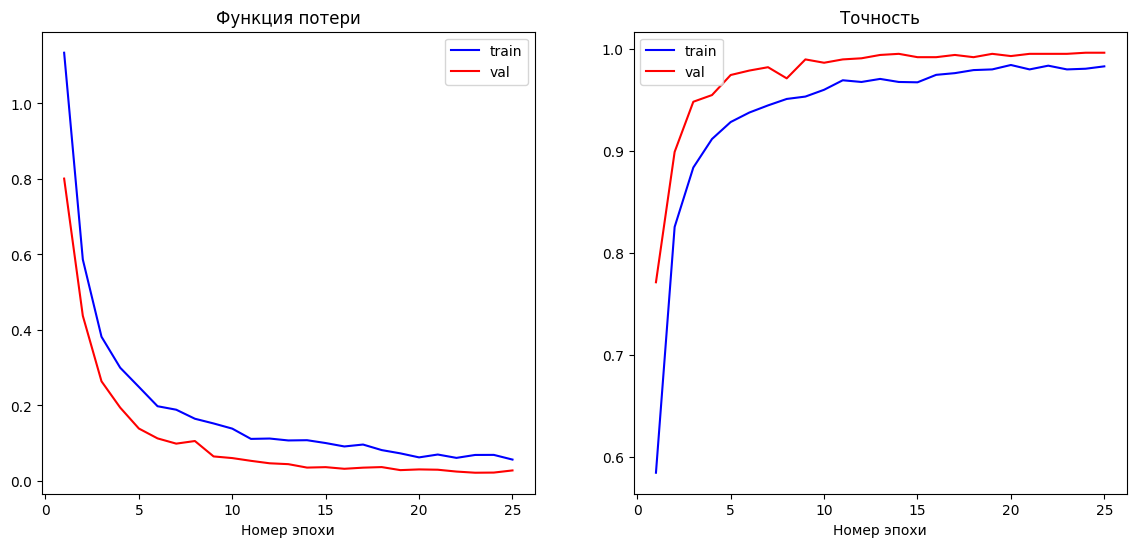

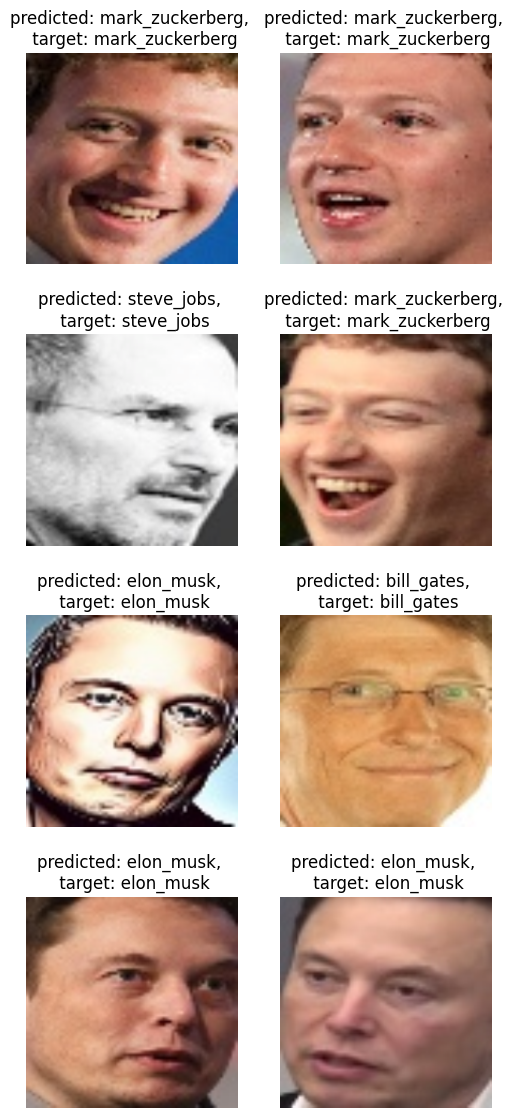

In [23]:
# Построим графики функции потерь и метрики точности
loss_acc_plot(loss_train_resnet34,
              acc_train_resnet34,
              loss_val_resnet34,
              acc_val_resnet34
              )

# Визуализируем предсказания обученной модели
visualize_model(resnet34)

### Промежуточные выводы 

+ Кривые функции потерь и метрики точности на обучении и валидации расположены близко друг к другу, чтоговорит об отсутствии переобучения.
+ Кривые вышли на плато - увеличение количества эпох обучения не требуется.
+ Время обучения модели составило более 5 минут.
+ Метрика точности достигает целевого порога > 0.85 на валидационной выборке и составляет 0.99. Попробуем сократить время обучения за счет применения файн-тюнинга предобученной модели

## Файн-тюнинг предобученной модели ResNet34

In [ ]:
# Загрузим модель предобученную модель resnet34
resnet34_ft = models.resnet34(weights='ResNet34_Weights.DEFAULT')

# Замораживаем веса модели
for parameter in resnet34_ft.parameters():
    parameter.requires_grad = False

# Переопределим последний слой классификатора под наше количество классов
resnet34_ft.fc = torch.nn.Linear(512, len(train_dataset.classes))

# Переносим модель на устройство
resnet34_ft = resnet34_ft.to(device)

# Задаем функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet34_ft.parameters(), lr=1e-3, weight_decay=1e-4)

# После заморозки весов модели мы переопределили слой классификатора поэтому
# обучаться будет только этот слой
resnet34_ft, loss_train_resnet34_ft, acc_train_resnet34_ft,\
    loss_val_resnet34_ft, acc_val_resnet34_ft = train_model(resnet34_ft,
                                                            device,
                                                            dataloaders,
                                                            criterion,
                                                            optimizer,
                                                            batch_size=batch_size,
                                                            num_epochs=num_epochs
                                                            )

----------
Epoch 1/25
----------


100%|██████████| 375/375 [00:06<00:00, 59.31it/s]


train Loss: 1.4292 Acc: 0.3993


100%|██████████| 115/115 [00:01<00:00, 66.91it/s]


val Loss: 1.2967 Acc: 0.5317
----------
Epoch 2/25
----------


100%|██████████| 375/375 [00:06<00:00, 59.84it/s]


train Loss: 1.1447 Acc: 0.6010


100%|██████████| 115/115 [00:01<00:00, 70.32it/s]


val Loss: 1.1617 Acc: 0.6116
----------
Epoch 3/25
----------


100%|██████████| 375/375 [00:06<00:00, 60.04it/s]


train Loss: 1.0152 Acc: 0.6513


100%|██████████| 115/115 [00:01<00:00, 66.88it/s]


val Loss: 1.0549 Acc: 0.6729
----------
Epoch 4/25
----------


100%|██████████| 375/375 [00:06<00:00, 59.74it/s]


train Loss: 0.9114 Acc: 0.7010


100%|██████████| 115/115 [00:01<00:00, 70.14it/s]


val Loss: 1.0116 Acc: 0.6947
----------
Epoch 5/25
----------


100%|██████████| 375/375 [00:06<00:00, 59.95it/s]


train Loss: 0.8644 Acc: 0.7190


100%|██████████| 115/115 [00:01<00:00, 68.24it/s]


val Loss: 0.9429 Acc: 0.7276
----------
Epoch 6/25
----------


100%|██████████| 375/375 [00:06<00:00, 60.22it/s]


train Loss: 0.8261 Acc: 0.7333


100%|██████████| 115/115 [00:01<00:00, 67.67it/s]


val Loss: 0.9015 Acc: 0.7298
----------
Epoch 7/25
----------


100%|██████████| 375/375 [00:06<00:00, 60.03it/s]


train Loss: 0.7930 Acc: 0.7427


100%|██████████| 115/115 [00:01<00:00, 67.77it/s]


val Loss: 0.8766 Acc: 0.7418
----------
Epoch 8/25
----------


100%|██████████| 375/375 [00:06<00:00, 59.65it/s]


train Loss: 0.7800 Acc: 0.7460


100%|██████████| 115/115 [00:01<00:00, 67.58it/s]


val Loss: 0.8382 Acc: 0.7549
----------
Epoch 9/25
----------


100%|██████████| 375/375 [00:06<00:00, 59.10it/s]


train Loss: 0.7450 Acc: 0.7507


100%|██████████| 115/115 [00:01<00:00, 67.82it/s]


val Loss: 0.8143 Acc: 0.7637
----------
Epoch 10/25
----------


100%|██████████| 375/375 [00:06<00:00, 59.98it/s]


train Loss: 0.7183 Acc: 0.7587


100%|██████████| 115/115 [00:01<00:00, 68.21it/s]


val Loss: 0.8217 Acc: 0.7374
----------
Epoch 11/25
----------


100%|██████████| 375/375 [00:06<00:00, 59.02it/s]


train Loss: 0.7179 Acc: 0.7610


100%|██████████| 115/115 [00:01<00:00, 68.34it/s]


val Loss: 0.7434 Acc: 0.7768
----------
Epoch 12/25
----------


100%|██████████| 375/375 [00:06<00:00, 58.58it/s]


train Loss: 0.7073 Acc: 0.7553


100%|██████████| 115/115 [00:01<00:00, 70.35it/s]


val Loss: 0.7983 Acc: 0.7582
----------
Epoch 13/25
----------


100%|██████████| 375/375 [00:06<00:00, 60.29it/s]


train Loss: 0.7056 Acc: 0.7557


100%|██████████| 115/115 [00:01<00:00, 69.14it/s]


val Loss: 0.7341 Acc: 0.7856
----------
Epoch 14/25
----------


100%|██████████| 375/375 [00:06<00:00, 60.01it/s]


train Loss: 0.6940 Acc: 0.7600


100%|██████████| 115/115 [00:01<00:00, 68.80it/s]


val Loss: 0.7242 Acc: 0.7812
----------
Epoch 15/25
----------


100%|██████████| 375/375 [00:06<00:00, 59.85it/s]


train Loss: 0.6573 Acc: 0.7757


100%|██████████| 115/115 [00:01<00:00, 68.56it/s]


val Loss: 0.7389 Acc: 0.7790
----------
Epoch 16/25
----------


100%|██████████| 375/375 [00:06<00:00, 60.05it/s]


train Loss: 0.6873 Acc: 0.7637


100%|██████████| 115/115 [00:01<00:00, 67.22it/s]


val Loss: 0.7247 Acc: 0.7867
----------
Epoch 17/25
----------


100%|██████████| 375/375 [00:06<00:00, 59.99it/s]


train Loss: 0.6449 Acc: 0.7770


100%|██████████| 115/115 [00:01<00:00, 66.01it/s]


val Loss: 0.6881 Acc: 0.7888
----------
Epoch 18/25
----------


100%|██████████| 375/375 [00:06<00:00, 59.66it/s]


train Loss: 0.6601 Acc: 0.7623


100%|██████████| 115/115 [00:01<00:00, 68.28it/s]


val Loss: 0.7100 Acc: 0.7626
----------
Epoch 19/25
----------


100%|██████████| 375/375 [00:06<00:00, 59.83it/s]


train Loss: 0.6307 Acc: 0.7893


100%|██████████| 115/115 [00:01<00:00, 66.14it/s]


val Loss: 0.6727 Acc: 0.7877
----------
Epoch 20/25
----------


100%|██████████| 375/375 [00:06<00:00, 59.94it/s]


train Loss: 0.6355 Acc: 0.7783


100%|██████████| 115/115 [00:01<00:00, 68.79it/s]


val Loss: 0.7017 Acc: 0.7801
----------
Epoch 21/25
----------


100%|██████████| 375/375 [00:06<00:00, 59.93it/s]


train Loss: 0.6123 Acc: 0.7927


100%|██████████| 115/115 [00:01<00:00, 68.29it/s]


val Loss: 0.6576 Acc: 0.7910
----------
Epoch 22/25
----------


100%|██████████| 375/375 [00:06<00:00, 59.96it/s]


train Loss: 0.6222 Acc: 0.7907


100%|██████████| 115/115 [00:01<00:00, 69.59it/s]


val Loss: 0.6539 Acc: 0.7932
----------
Epoch 23/25
----------


100%|██████████| 375/375 [00:06<00:00, 59.45it/s]


train Loss: 0.5974 Acc: 0.7907


100%|██████████| 115/115 [00:01<00:00, 66.02it/s]


val Loss: 0.6782 Acc: 0.7888
----------
Epoch 24/25
----------


100%|██████████| 375/375 [00:06<00:00, 60.03it/s]


train Loss: 0.6164 Acc: 0.7883


100%|██████████| 115/115 [00:01<00:00, 67.85it/s]


val Loss: 0.6603 Acc: 0.7932
----------
Epoch 25/25
----------


100%|██████████| 375/375 [00:06<00:00, 59.84it/s]


train Loss: 0.6187 Acc: 0.7897


100%|██████████| 115/115 [00:01<00:00, 67.09it/s]

val Loss: 0.6538 Acc: 0.7954
Время обучения: 3m 19s


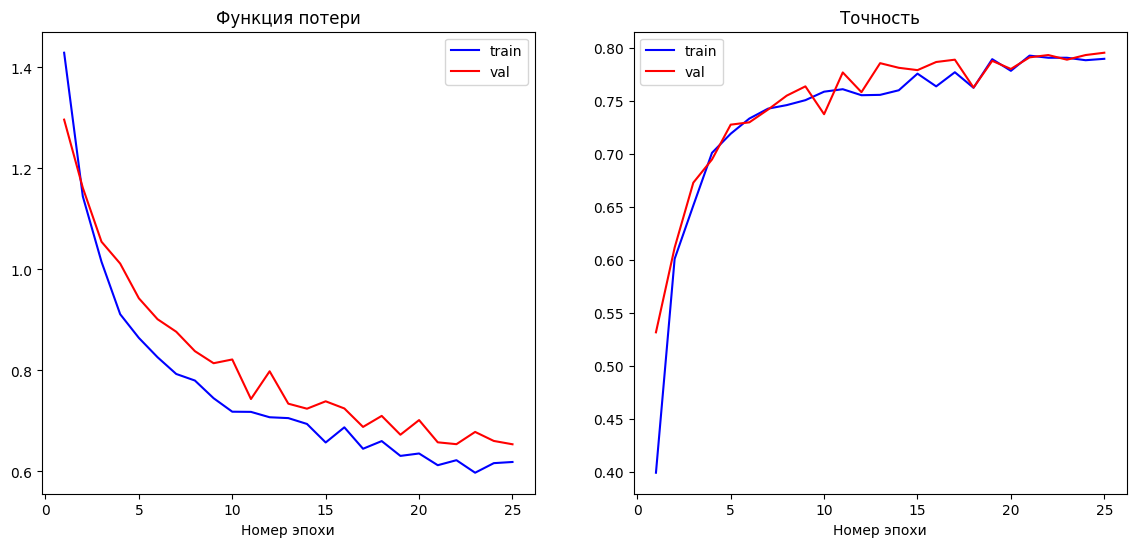

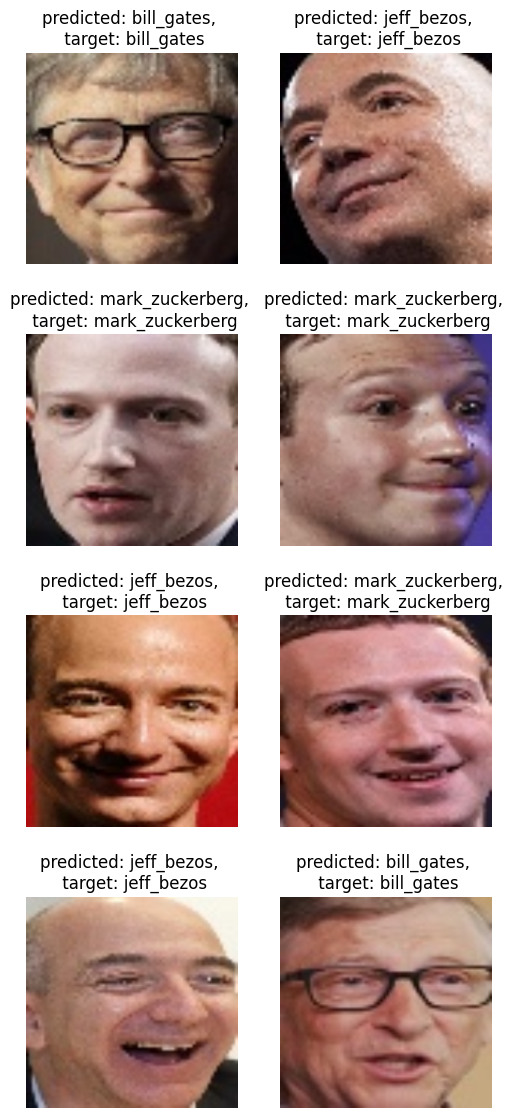

In [25]:
# Построим графики функции потерь и метрики точности
loss_acc_plot(loss_train_resnet34_ft,
              acc_train_resnet34_ft,
              loss_val_resnet34_ft,
              acc_val_resnet34_ft
              )

# Визуализируем предсказания обученной модели
visualize_model(resnet34_ft)

### Промежуточные выводы 
+ Кривые функции потерь и метрики точности на обучении и валидации расположены близко друг к другу, что говорит об отсутствии переобучения.
+ Кривые вышли на плато - увеличение количества эпох обучения не требуется.
+ Нам удалось сократить время обучения до 3 с небольшим минут за счет заморозки предобученных слоев и обучения только слоя классификатора.
+ Метрика точности не достигает целевого порога > 0.85 на валидационной выборке и составляет 0.79. Стоит попробовать разморозить часть сверточных слоев модели.

## Обновление весов для для блока layer4 и классификатора предобученной модели ResNet34

In [26]:
# Загрузим модель предобученную модель resnet34
resnet34_conv = models.resnet34(weights='ResNet34_Weights.DEFAULT')

# Переопределим последний слой классификатора под наше количество классов
resnet34_conv.fc = torch.nn.Linear(512, len(train_dataset.classes))

# Замораживаем часть первых слоев модели
for param in resnet34_conv.parameters():
    param.requires_grad = False

# Разрешаем обновление весов для блока layer4 и классификатора        
for param in resnet34_conv.layer4.parameters():
    param.requires_grad = True
    
for param in resnet34_conv.fc.parameters():
    param.requires_grad = True
  
# Переносим модель на устройство
resnet34_conv = resnet34_conv.to(device)

# Задаем функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet34_conv.parameters(), lr=1e-3, weight_decay=1e-4)

# Обучаем модель
resnet34_conv, loss_train_resnet34_conv, acc_train_resnet34_conv,\
    loss_val_resnet34_conv, acc_val_resnet34_conv = train_model(resnet34_conv,
                                                                device,
                                                                dataloaders,
                                                                criterion,
                                                                optimizer,
                                                                batch_size=batch_size,
                                                                num_epochs=num_epochs
                                                                )

----------
Epoch 1/25
----------


100%|██████████| 375/375 [00:07<00:00, 48.63it/s]


train Loss: 1.2056 Acc: 0.5493


100%|██████████| 115/115 [00:01<00:00, 64.70it/s]


val Loss: 1.0163 Acc: 0.6477
----------
Epoch 2/25
----------


100%|██████████| 375/375 [00:07<00:00, 47.95it/s]


train Loss: 0.7795 Acc: 0.7483


100%|██████████| 115/115 [00:01<00:00, 69.05it/s]


val Loss: 0.7439 Acc: 0.7877
----------
Epoch 3/25
----------


100%|██████████| 375/375 [00:07<00:00, 48.27it/s]


train Loss: 0.6097 Acc: 0.8040


100%|██████████| 115/115 [00:01<00:00, 68.49it/s]


val Loss: 0.5665 Acc: 0.8501
----------
Epoch 4/25
----------


100%|██████████| 375/375 [00:07<00:00, 48.52it/s]


train Loss: 0.5141 Acc: 0.8270


100%|██████████| 115/115 [00:01<00:00, 67.52it/s]


val Loss: 0.4994 Acc: 0.8348
----------
Epoch 5/25
----------


100%|██████████| 375/375 [00:07<00:00, 47.97it/s]


train Loss: 0.4300 Acc: 0.8597


100%|██████████| 115/115 [00:01<00:00, 68.23it/s]


val Loss: 0.4164 Acc: 0.8676
----------
Epoch 6/25
----------


100%|██████████| 375/375 [00:07<00:00, 49.04it/s]


train Loss: 0.3814 Acc: 0.8740


100%|██████████| 115/115 [00:01<00:00, 70.18it/s]


val Loss: 0.3168 Acc: 0.9147
----------
Epoch 7/25
----------


100%|██████████| 375/375 [00:07<00:00, 51.51it/s]


train Loss: 0.3579 Acc: 0.8793


100%|██████████| 115/115 [00:01<00:00, 72.10it/s]


val Loss: 0.2709 Acc: 0.9354
----------
Epoch 8/25
----------


100%|██████████| 375/375 [00:07<00:00, 50.87it/s]


train Loss: 0.3222 Acc: 0.8907


100%|██████████| 115/115 [00:01<00:00, 74.40it/s]


val Loss: 0.2554 Acc: 0.9333
----------
Epoch 9/25
----------


100%|██████████| 375/375 [00:07<00:00, 51.54it/s]


train Loss: 0.3033 Acc: 0.9043


100%|██████████| 115/115 [00:01<00:00, 73.56it/s]


val Loss: 0.2391 Acc: 0.9398
----------
Epoch 10/25
----------


100%|██████████| 375/375 [00:07<00:00, 51.88it/s]


train Loss: 0.2954 Acc: 0.9067


100%|██████████| 115/115 [00:01<00:00, 74.21it/s]


val Loss: 0.2084 Acc: 0.9464
----------
Epoch 11/25
----------


100%|██████████| 375/375 [00:07<00:00, 51.21it/s]


train Loss: 0.2883 Acc: 0.9007


100%|██████████| 115/115 [00:01<00:00, 68.28it/s]


val Loss: 0.1867 Acc: 0.9497
----------
Epoch 12/25
----------


100%|██████████| 375/375 [00:07<00:00, 49.91it/s]


train Loss: 0.2506 Acc: 0.9190


100%|██████████| 115/115 [00:01<00:00, 74.22it/s]


val Loss: 0.1847 Acc: 0.9508
----------
Epoch 13/25
----------


100%|██████████| 375/375 [00:07<00:00, 50.88it/s]


train Loss: 0.2384 Acc: 0.9183


100%|██████████| 115/115 [00:01<00:00, 73.89it/s]


val Loss: 0.1734 Acc: 0.9497
----------
Epoch 14/25
----------


100%|██████████| 375/375 [00:07<00:00, 51.12it/s]


train Loss: 0.2398 Acc: 0.9230


100%|██████████| 115/115 [00:01<00:00, 71.65it/s]


val Loss: 0.1919 Acc: 0.9409
----------
Epoch 15/25
----------


100%|██████████| 375/375 [00:07<00:00, 48.89it/s]


train Loss: 0.2217 Acc: 0.9260


100%|██████████| 115/115 [00:01<00:00, 71.46it/s]


val Loss: 0.1468 Acc: 0.9617
----------
Epoch 16/25
----------


100%|██████████| 375/375 [00:07<00:00, 50.93it/s]


train Loss: 0.2176 Acc: 0.9263


100%|██████████| 115/115 [00:01<00:00, 74.75it/s]


val Loss: 0.1397 Acc: 0.9639
----------
Epoch 17/25
----------


100%|██████████| 375/375 [00:07<00:00, 51.16it/s]


train Loss: 0.1931 Acc: 0.9373


100%|██████████| 115/115 [00:01<00:00, 73.77it/s]


val Loss: 0.1273 Acc: 0.9683
----------
Epoch 18/25
----------


100%|██████████| 375/375 [00:07<00:00, 48.95it/s]


train Loss: 0.2124 Acc: 0.9323


100%|██████████| 115/115 [00:01<00:00, 74.06it/s]


val Loss: 0.1464 Acc: 0.9661
----------
Epoch 19/25
----------


100%|██████████| 375/375 [00:07<00:00, 51.24it/s]


train Loss: 0.2083 Acc: 0.9320


100%|██████████| 115/115 [00:01<00:00, 73.64it/s]


val Loss: 0.1302 Acc: 0.9595
----------
Epoch 20/25
----------


100%|██████████| 375/375 [00:07<00:00, 50.92it/s]


train Loss: 0.1887 Acc: 0.9397


100%|██████████| 115/115 [00:01<00:00, 71.87it/s]


val Loss: 0.1381 Acc: 0.9650
----------
Epoch 21/25
----------


100%|██████████| 375/375 [00:07<00:00, 50.00it/s]


train Loss: 0.1636 Acc: 0.9437


100%|██████████| 115/115 [00:01<00:00, 67.53it/s]


val Loss: 0.1223 Acc: 0.9639
----------
Epoch 22/25
----------


100%|██████████| 375/375 [00:07<00:00, 50.38it/s]


train Loss: 0.1647 Acc: 0.9513


100%|██████████| 115/115 [00:01<00:00, 72.84it/s]


val Loss: 0.1067 Acc: 0.9650
----------
Epoch 23/25
----------


100%|██████████| 375/375 [00:07<00:00, 50.91it/s]


train Loss: 0.1618 Acc: 0.9503


100%|██████████| 115/115 [00:01<00:00, 73.79it/s]


val Loss: 0.1188 Acc: 0.9694
----------
Epoch 24/25
----------


100%|██████████| 375/375 [00:07<00:00, 49.11it/s]


train Loss: 0.1505 Acc: 0.9560


100%|██████████| 115/115 [00:01<00:00, 70.17it/s]


val Loss: 0.1019 Acc: 0.9694
----------
Epoch 25/25
----------


100%|██████████| 375/375 [00:07<00:00, 49.12it/s]


train Loss: 0.1547 Acc: 0.9497


100%|██████████| 115/115 [00:01<00:00, 72.39it/s]

val Loss: 0.1034 Acc: 0.9705
Время обучения: 3m 48s


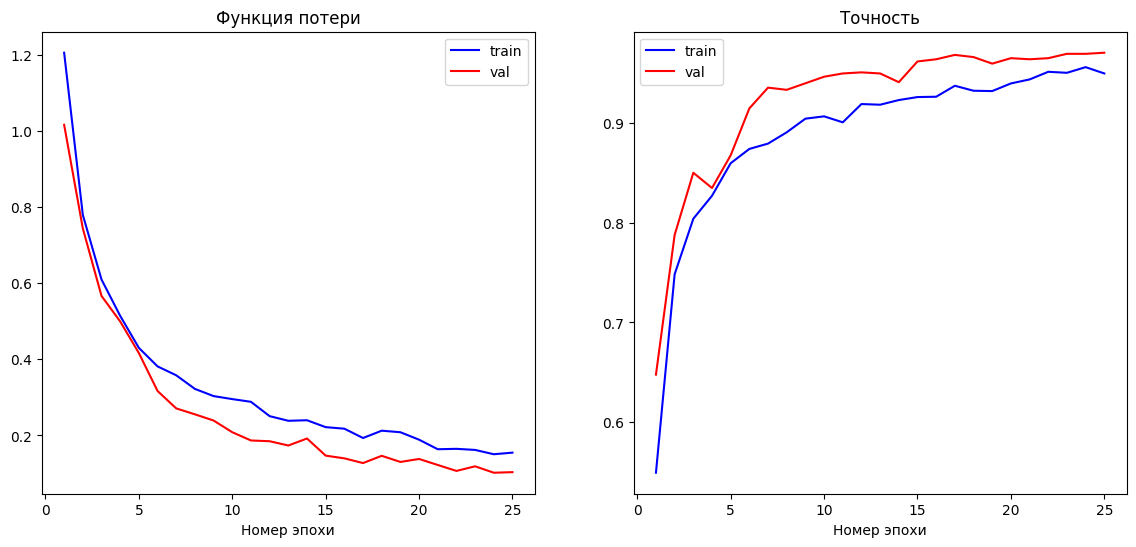

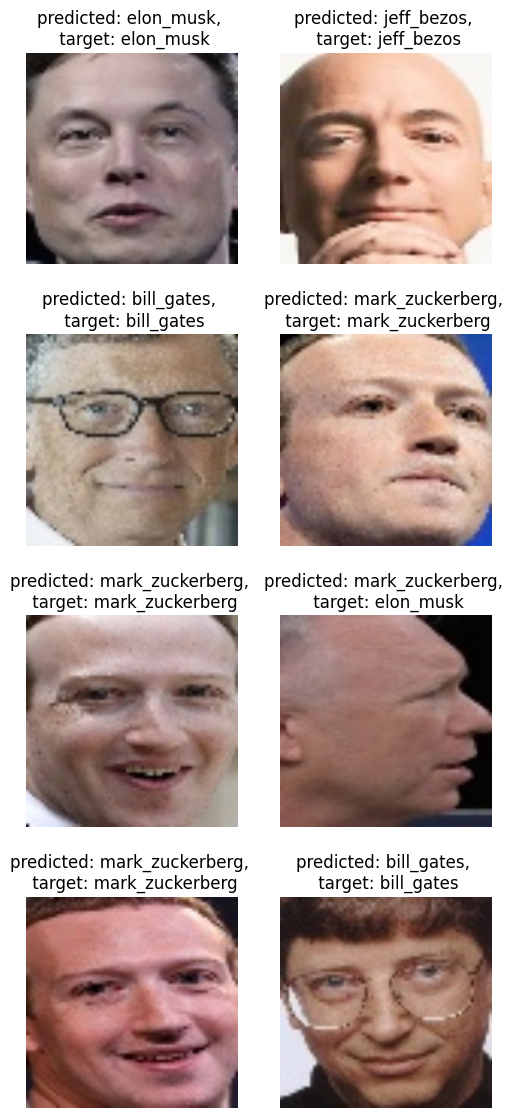

In [27]:
# Построим графики функции потерь и метрики точности
loss_acc_plot(loss_train_resnet34_conv,
              acc_train_resnet34_conv,
              loss_val_resnet34_conv,
              acc_val_resnet34_conv
              )

# Визуализируем предсказания обученной модели
visualize_model(resnet34_conv)

### Промежуточные выводы 
+ Кривые функции потерь и метрики точности на обучении и валидации расположены близко друг к другу, что говорит об отсутствии переобучения.
+ Кривые вышли на плато - увеличение количества эпох обучения не требуется.
+ Время обучения увеличилось почти до 4 минут.
+ Метрика точности достигает целевого порога > 0.85 на валидационной выборке и составляет 0.97.

## Выводы 

+ Построены модели многоклассовой классификации с использованием предобученной модели ResNet34.
+ Лучшая точность на валидационной выборке достигается на полностью переобученной модели использующей предобученные веса в качестве начальных значений. Точность данной модели составляет 0.99. Однако и время обучения такой модели максимально - более 5 минут.
+ Применение файн-тюнинга предобученной модели ResNet34 позволило сократить время обучения до 3 с небольшим минут, но оказалось недостаточным для достижения требуемого значения точности > 0.85 на валидационной выборке. Точность на валидационной выборке составила около 0.79.
+ Обучение последних слоев сверточного блока предобученной модели ResNet34 совместно с файн-тюнингом позволило достичь значения точности на валидационной выборке 0.97 при времени обучения менее 4 минут. При увеличении объема обучающих данных такой выигрыш по времени при незначительно падении точности может играть важную роль.
+ В целом с решением поставленной задачи лучше всего справилась полностью переобученная модель использующая предобученные веса модели ResNet34 в качестве начальных значений.